In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import special,optimize,integrate
import pickle
import pandas as pd
import os
import matplotlib.colors as mcolors
    
from scipy.optimize import curve_fit,minimize_scalar
from scipy.integrate import simps

# A bunch of functions...

In [2]:
def NB_model(k_arr,i_f,p,d_N=3):
    '''
    The fragmentation model by Charalambous (2015)
    k_arr: the size classes
    i_f: the fragmentation 'index' (denoted by f in the paper)
    p: fragmentation probability
    d_N: spatial dimensionality
    '''
    
    pmf_m = (scipy.special.gamma(k_arr+i_f) / (scipy.special.gamma(k_arr+1)*scipy.special.gamma(i_f)))*(p**k_arr)*(1-p)**i_f
    pmf_N = 2**(d_N*k_arr) * pmf_m
    
    return pmf_m,pmf_N


def if_rate(setting):
    '''
    Some fragmentation settings based on the paper by Song et al. (2017)
    '''
    if isinstance(setting,str):
        if setting == 'PP6':
            t_UV = 0.5 #experimental time, years
            t_env = 4.2/2  #estimated evironmental time, years
            t_i_f = 3.5e-1 #fragmentation index at experimental time        
        elif setting == 'PE12':
            t_UV = 1. #experimental time, years
            t_env = 4.2  #estimated evironmental time, years
            t_i_f = 7.4e-2 #fragmentation index at experimental time           
        elif setting == 'PP12':
            t_UV = 1.0 #experimental time, years
            t_env = 4.2  #estimated evironmental time, years
            t_i_f = 2.9e-1 #fragmentation index at experimental time        
        else:
            print('not implemented')
            
        d_if_year = (t_i_f / t_UV) / t_env
        d_if_week = d_if_year / 52
    elif isinstance(setting,float):
        d_if_week = setting
    return d_if_week


def read_pickle(filename):
    infile = open(filename,'rb')
    data = pickle.load(infile)
    infile.close()
    return data


def get_ocean_p(filename,setting,l_arr,shape='el950',quantile=.5,PLOT=True):
    '''
    Get ocean transition probabilities
    setting can be baseline (constant, Stokes factor of 1), or variable, where
    for each particle size we have a different transpoty probability
    '''
    data_p = read_pickle(filename)
    
    if setting == 'baseline':
        P_oo = data_p['p_oo_dist'][1.0]
        P_oc = data_p['p_oc_dist'][1.0]
        P_co = data_p['p_co_dist'][1.0]
        P_cc = data_p['p_cc_dist'][1.0]
    elif setting == 'variable':
        
        data_S = read_pickle('./Stokes_influence_factor.pickle')

        #get stokes influence factor for the l_arr
        SIF = np.interp(l_arr,np.flip(data_S['l']),np.flip(data_S[shape][quantile]))
        
        #Stokes influence factor inserted in the Lag. simulation, with their corresponding transition probabilities        
        SIF_sim = np.linspace(0,1,6,endpoint=True)
        P_oo_sim = np.array([data_p['p_oo_dist'][key_] for key_ in data_p['p_oo_dist'].keys()])[:-1]
        P_oc_sim = np.array([data_p['p_oc_dist'][key_] for key_ in data_p['p_oc_dist'].keys()])[:-1]
        P_co_sim = np.array([data_p['p_co_dist'][key_] for key_ in data_p['p_co_dist'].keys()])[:-1]
        P_cc_sim = np.array([data_p['p_cc_dist'][key_] for key_ in data_p['p_cc_dist'].keys()])[:-1]
        
        # transition probabilities are linearly interpolated for the given l_arr
        P_oo = np.interp(SIF,SIF_sim,P_oo_sim)          
        P_oc = np.interp(SIF,SIF_sim,P_oc_sim)
        P_cc = np.interp(SIF,SIF_sim,P_cc_sim)
        P_co = np.interp(SIF,SIF_sim,P_co_sim)
        
        if PLOT:
            cmap = plt.cm.tab10
            linestyles = ['o-','v-','^-','d-','*-','x-','+-']
            
            fig,ax = plt.subplots(1,figsize=(6,3.5))
            for i1,q_ in enumerate(list(data_S[shape].keys())[:-1]):
                ax.semilogx(np.flip(data_S['l']),np.flip(data_S[shape][q_]),linestyles[i1],color=cmap(i1),label='Quantile %2.2f' % q_)
            ax.set_ylabel(r'$v_{Stokes}(z)$ / $v_{Stokes}(0)$ [-]')
            ax.set_xlabel('Particle size [mm]')
            ax.legend(title='Wind/wave statistics:',loc='lower right')
        
            fig,ax = plt.subplots(1,figsize=(6,3.5))
            ax.plot(np.linspace(0,1,6),P_oo_sim,linestyles[0],color=cmap(0),label='$P_{oo}$')
            ax.plot(np.linspace(0,1,6),P_oc_sim,linestyles[1],color=cmap(1),label='$P_{oc}$')
            ax.plot(np.linspace(0,1,6),P_cc_sim,linestyles[2],color=cmap(2),label='$P_{cc}$')
            ax.plot(np.linspace(0,1,6),P_co_sim,linestyles[3],color=cmap(3),label='$P_{co}$')
            ax.set_xlabel(r'$v_{Stokes}(z)$ / $v_{Stokes}(0)$ [-]')
            ax.set_ylabel('Transition probability')
            ax.legend(loc='center right')
        
            fig,ax = plt.subplots(1,figsize=(6,3.5))
            ax.semilogx(l_arr,P_oo,linestyles[0],color=cmap(0),label='$P_{oo}$')
            ax.semilogx(l_arr,P_oc,linestyles[1],color=cmap(1),label='$P_{oc}$')
            ax.semilogx(l_arr,P_cc,linestyles[2],color=cmap(2),label='$P_{cc}$')
            ax.semilogx(l_arr,P_co,linestyles[3],color=cmap(3),label='$P_{co}$')
            ax.set_xlabel('Particle size [mm]')
            ax.set_ylabel('Transition probability')
            ax.legend(loc='center right')        
            
    return P_oo,P_oc,P_co,P_cc


def get_rt_Hinata(shape='el950'):
    '''
    resuspension time scale from Hinata et al. (2017)
    '''
    data_S = read_pickle('./Stokes_influence_factor.pickle')
    
    #get stokes influence factor for the l_arr
    wb = np.interp(l_arr,np.flip(data_S['l']),np.flip(data_S['wb_'+shape]))
    tau_bc = 2.6e2*wb + 7.1
    return tau_bc


def create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s_mean,T_NB_N,T_NB_m):
    """
    Function to set up the transition matrix
    ----------
    k_arr : array with size classes
    P_sim_oo : ocean-ocean transport probability (0-1)
    P_sim_oc : ocean-coast transport probability (0-1)
    P_sim_co : coast-ocean transport probability (0-1)
    P_sim_cc : coast-coast transport probability (0-1)
    tau_bc : resuspension time scale
    tau_cb : beaching time scale
    p_s_mean : sink probability
    T_NB_N: fragmentation transition matrix, abundance
    T_NB_m: fragmentation transition matrix, mass
    
    Returns
    -------
    T_mat_m and T_mat_N: transition matrices in terms of mass and abundance

    """
    
    def tau_to_lambda(tau):
        return 1 - np.exp(-1/tau)
    #--------ocean----------
    P_os = p_s_mean
    
    P_oo = (P_sim_oo / (P_sim_oo + P_sim_oc)) * (1-P_os)
    P_oc = (P_sim_oc / (P_sim_oo + P_sim_oc)) * (1-P_os)
    
    if isinstance(P_oo,np.ndarray):
        assert(np.abs(1 - (P_oo+P_oc+P_os)) < 1e-10).all() 
    else:
        assert(np.abs(1 - (P_oo+P_oc+P_os)) < 1e-10)

    #--------coast----------
    P_cs = p_s_mean
    P_sim_cb = tau_to_lambda(tau_cb/7) #daily to weekly probability

    P_norm_co = P_sim_co / (P_sim_co + P_sim_cc) #normalize to one
    P_norm_cc = P_sim_cc / (P_sim_co + P_sim_cc)
    
    P_norm2_co = P_norm_co * (1-P_sim_cb) #equal fraction needs to be substracted which ends up on beach
    P_norm2_cc = P_norm_cc * (1-P_sim_cb)
    
    P_co = P_norm2_co * (1-P_cs) #sink fractions substracted as well
    P_cc = P_norm2_cc * (1-P_cs)
    P_cb = P_sim_cb * (1-P_cs)
    
    if isinstance(P_cc,np.ndarray):
        assert(np.abs(1 - (P_cc+P_co+P_cs+P_cb)) < 1e-10).all()    
    else:
        assert(np.abs(1 - (P_cc+P_co+P_cs+P_cb)) < 1e-10)   
        
    #--------beach----------
    P_bs = p_s_mean
    P_sim_bc = tau_to_lambda(tau_bc/7)
    P_sim_bb = 1 - P_sim_bc
    
    P_bb = (P_sim_bb / (P_sim_bb + P_sim_bc)) * (1-P_bs)
    P_bc = (P_sim_bc / (P_sim_bb + P_sim_bc)) * (1-P_bs)
    
    if isinstance(P_bb,np.ndarray):
        assert(np.abs(1 - (P_bb+P_bc+P_bs)) < 1e-10).all()
    else:
        assert(np.abs(1 - (P_bb+P_bc+P_bs)) < 1e-10)
        
        
    P_mat = {}
    for var_,name_ in zip([P_oo,P_oc,P_co,P_cc,P_cb,P_bc,P_bb],['oo','oc','co','cc','cb','bc','bb']):
        if isinstance(var_,np.ndarray):
            P_mat[name_] = np.diag(var_)
        elif isinstance(var_,float):
            P_mat[name_] = var_ * np.eye(len(k_arr))
        else:
            raise RuntimeError('invalid transition probability size')
    
    for var_,name_ in zip([P_bc,P_bb],['bc','bb']): #fragmentation, handle differently
        if isinstance(var_,np.ndarray):
            P_mat[name_+'_N'] = (np.ones([len(k_arr),len(k_arr)])*var_).T * T_NB_N
            P_mat[name_+'_m'] = (np.ones([len(k_arr),len(k_arr)])*var_).T * T_NB_m
        elif isinstance(var_,float):
            P_mat[name_+'_N'] = var_ * T_NB_N
            P_mat[name_+'_m'] = var_ * T_NB_m
        else:
            raise RuntimeError('invalid transition probability size')        
    
    
    T_mat_m = np.zeros([3*len(k_arr),3*len(k_arr)])
    T_mat_N = np.zeros([3*len(k_arr),3*len(k_arr)])
    
    T_mat_m[index_o[0]:index_o[-1]+1,index_o[0]:index_o[-1]+1] = P_mat['oo']
    T_mat_m[index_o[0]:index_o[-1]+1,index_c[0]:index_c[-1]+1] = P_mat['co']
    T_mat_m[index_c[0]:index_c[-1]+1,index_o[0]:index_o[-1]+1] = P_mat['oc']
    T_mat_m[index_c[0]:index_c[-1]+1,index_c[0]:index_c[-1]+1] = P_mat['cc']
    T_mat_m[index_b[0]:index_b[-1]+1,index_c[0]:index_c[-1]+1] = P_mat['cb']
    # 在beach上碎裂的同时可能进入coast
    T_mat_m[index_c[0]:index_c[-1]+1,index_b[0]:index_b[-1]+1] = P_mat['bc_m']
    T_mat_m[index_b[0]:index_b[-1]+1,index_b[0]:index_b[-1]+1] = P_mat['bb_m']
    
    T_mat_N[index_o[0]:index_o[-1]+1,index_o[0]:index_o[-1]+1] = P_mat['oo']
    T_mat_N[index_o[0]:index_o[-1]+1,index_c[0]:index_c[-1]+1] = P_mat['co']
    T_mat_N[index_c[0]:index_c[-1]+1,index_o[0]:index_o[-1]+1] = P_mat['oc']
    T_mat_N[index_c[0]:index_c[-1]+1,index_c[0]:index_c[-1]+1] = P_mat['cc']
    T_mat_N[index_b[0]:index_b[-1]+1,index_c[0]:index_c[-1]+1] = P_mat['cb']
    T_mat_N[index_c[0]:index_c[-1]+1,index_b[0]:index_b[-1]+1] = P_mat['bc_N']
    T_mat_N[index_b[0]:index_b[-1]+1,index_b[0]:index_b[-1]+1] = P_mat['bb_N']
    
    dict_save = {}
    dict_save['oo'] = P_oo
    dict_save['oc'] = P_oc
    dict_save['co'] = P_co
    dict_save['cc'] = P_cc
    dict_save['cb'] = P_cb
    dict_save['bb'] = P_bb
    dict_save['bc'] = P_bc
    dict_save['s'] = p_s_mean

    return T_mat_m,T_mat_N,dict_save


def calculate_steady_state_m2(T_mat_m, input_week, input_fraction_beach=1.):
    m_arr_0 = np.zeros(3*len(k_arr))
    m_arr_0[index_b[0]] = input_week*input_fraction_beach
    m_arr_0[index_c[0]] = input_week*(1-input_fraction_beach)

    m1 = np.linalg.inv(np.eye(len(k_arr)*3) - T_mat_m)
    m2 = np.dot(T_mat_m,m_arr_0)
    w_ss = np.dot(m1,m2)
    mass_ocean_meshsize = w_ss[0:len(k_arr)][l_arr>0.1].sum()
    mass_coast_meshsize = w_ss[len(k_arr):2*len(k_arr)][l_arr>0.1].sum()
    mass_floating_ss = mass_ocean_meshsize + mass_coast_meshsize
    return mass_floating_ss
    

def J_ps_ss(p_s_log,afloat_mean,input_week,input_fraction_beach,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,T_NB_N,T_NB_m):
    """
    cost function: Find the sink probability such that the steady state floating mass is satisfied
    """
    p_s_ = 10**p_s_log
    
    if p_s_ < 0 or p_s_ > 1:
        res = 1e6
    else:
        T_mat_m,_,_ = create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s_,T_NB_N,T_NB_m)
        mass_floating_ss = calculate_steady_state_m2(T_mat_m, input_week,input_fraction_beach)
        res = np.abs(mass_floating_ss - afloat_mean)
    return res


def J_ps_ss2(p_s_log,afloat_mean,input_week,input_fraction_beach,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,T_NB_N1,T_NB_m1,T_NB_N2,T_NB_m2,frac1,frac2):
    """
    cost function: Find the sink probability such that the steady state floating mass is satisfied
    valid for two types of materials
    """
    p_s_ = 10**p_s_log
    
    if p_s_ < 0 or p_s_ > 1:
        res = 1e6

    T_mat_m1,_,_ = create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s_,T_NB_N1,T_NB_m1)
    mass_floating_ss1 = calculate_steady_state_m2(T_mat_m1, input_week*frac1,input_fraction_beach)

    T_mat_m2,_,_ = create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s_,T_NB_N2,T_NB_m2)
    mass_floating_ss2 = calculate_steady_state_m2(T_mat_m2, input_week*frac2,input_fraction_beach)
    res = np.abs((mass_floating_ss1+mass_floating_ss2) - afloat_mean)    
    return res


def calculate_ss_m_N(T_mat_m, T_mat_N, input_week, input_fraction_beach=1.):
    '''
    Calculate steady-state values for the MSD and NSD, see SI for derivation
    '''
    input_fraction_coast = 1. - input_fraction_beach
    if input_fraction_beach < 1:
        print('beach input frac.: %f, coastal water: %f' % (input_fraction_beach,input_fraction_coast))
    
    m_arr_0 = np.zeros(3*len(k_arr))
    m_arr_0[index_b[0]] = input_week*input_fraction_beach
    m_arr_0[index_c[0]] = input_week*input_fraction_coast

    m1 = np.linalg.inv(np.eye(len(k_arr)*3) - T_mat_m)
    m2 = np.dot(T_mat_m,m_arr_0)
    m_ss = np.dot(m1,m2)

    N_arr_0 = np.zeros(3*len(k_arr))
    N_arr_0[index_b[0]] = input_fraction_beach
    N_arr_0[index_c[0]] = input_fraction_coast
    
    N1 = np.linalg.inv(np.eye(len(k_arr)*3) - T_mat_N)
    N2 = np.dot(T_mat_N,N_arr_0)
    N_ss = np.dot(N1,N2)    
    
    return m_ss,N_ss


def plot_evolution_N(ax_col,T_mat_N):
    '''
    plot temporal evolution of the NSD over time
    '''
    cmap = plt.cm.viridis
    N_arr_0 = np.zeros(3*len(k_arr))
    N_arr_0[index_b[0]] = 1 # 初始的微塑料输入
    
    count_plot = 0
    max_year = 5 # 模拟五年的变化
    plot_every = 26 # 每隔26周画一次图
    N_arr = N_arr_0.copy()
    for i1 in range(52*max_year):
        
        N_arr = np.dot(T_mat_N,N_arr+N_arr_0)
    
    
        N_o = N_arr[index_o]
        N_c = N_arr[index_c]
        N_b = N_arr[index_b]
    
        if i1 % plot_every == 0:
            color_ = (count_plot*plot_every) / (52*max_year) + (plot_every/(52*max_year))
            ax_col[0].loglog(l_arr,N_o,'o-',color=cmap(color_),label='week %i' % (i1+1))
            
            ax_col[1].loglog(l_arr,N_c,'o-',color=cmap(color_))
            
            ax_col[2].loglog(l_arr,N_b,'o-',color=cmap(color_))
            
            mask_slope = l_arr < L0
            
            slopes_b = np.log2(N_b[mask_slope][1:])-np.log2(N_b[mask_slope][:-1])
            slopes_c = np.log2(N_c[mask_slope][1:])-np.log2(N_c[mask_slope][:-1])
            slopes_o = np.log2(N_o[mask_slope][1:])-np.log2(N_o[mask_slope][:-1])
        
            print('mean slopes, beach: %3.3f, coast: %3.3f, ocean: %3.3f' % (slopes_b.mean(),slopes_c.mean(),slopes_o.mean()))
            count_plot += 1
    
    slope_ss_b = np.log2(N_ss[index_b][mask_slope][1:])-np.log2(N_ss[index_b][mask_slope][:-1])
    slope_ss_c = np.log2(N_ss[index_c][mask_slope][1:])-np.log2(N_ss[index_c][mask_slope][:-1])
    slope_ss_o = np.log2(N_ss[index_o][mask_slope][1:])-np.log2(N_ss[index_o][mask_slope][:-1])
    print('SS slopes, beach: %3.3f, coast: %3.3f, ocean: %3.3f' % (slope_ss_b.mean(),slope_ss_c.mean(),slope_ss_o.mean()))
    ax_col[0].loglog(l_arr,N_ss[index_o],'r--',label='steady state')
    ax_col[1].loglog(l_arr,N_ss[index_c],'r--')
    ax_col[2].loglog(l_arr,N_ss[index_b],'r--')
    
    set_plot_labels(ax_col,[N_o,N_c,N_b],labels=['Ocean','Coast','Beach'],collabel='(a)')

    dz = 9
    for ax_,N_,label_ in zip(ax_col,[N_o,N_c,N_b],['Ocean','Coast','Beach']):
        ax_max = np.log10(np.max(N_))
        ax_min = ax_max - dz
        ax_.set_ylim(10**ax_min,10**ax_max)

    ax_col[0].legend(loc='lower left',fontsize=legendsize)
    ax_col[0].set_ylabel('Abundance [n]',fontsize=labelsize)


def plot_evolution_m(ax_col,T_mat_m,input_week):
    '''
    plot temporal evolution of the MSD over time
    '''
    cmap = plt.cm.viridis
    m_arr_0 = np.zeros(3*len(k_arr))
    m_arr_0[index_b[0]] = input_week
    
    count_plot = 0
    max_year = 5
    plot_every = 26
    m_arr = m_arr_0.copy()
    for i1 in range(52*max_year):
        
        m_arr = np.dot(T_mat_m,m_arr+m_arr_0)
    
    
        m_o = m_arr[index_o]
        m_c = m_arr[index_c]
        m_b = m_arr[index_b]
    
        if i1 % plot_every == 0:
            color_ = (count_plot*plot_every) / (52*max_year) + (plot_every/(52*max_year))
            ax_col[0].loglog(l_arr,m_o,'o-',color=cmap(color_),label='week %i' % (i1+1))
            
            ax_col[1].loglog(l_arr,m_c,'o-',color=cmap(color_))
            
            ax_col[2].loglog(l_arr,m_b,'o-',color=cmap(color_))
            
            mask_slope = l_arr < L0
            
            slopes_b = np.log2(m_b[mask_slope][1:])-np.log2(m_b[mask_slope][:-1])
            slopes_c = np.log2(m_c[mask_slope][1:])-np.log2(m_c[mask_slope][:-1])
            slopes_o = np.log2(m_o[mask_slope][1:])-np.log2(m_o[mask_slope][:-1])
        
            print('mean slopes, beach: %3.3f, coast: %3.3f, ocean: %3.3f' % (slopes_b.mean(),slopes_c.mean(),slopes_o.mean()))
            count_plot += 1
    
    slope_ss_b = np.log2(m_ss[index_b][mask_slope][1:])-np.log2(m_ss[index_b][mask_slope][:-1])
    slope_ss_c = np.log2(m_ss[index_c][mask_slope][1:])-np.log2(m_ss[index_c][mask_slope][:-1])
    slope_ss_o = np.log2(m_ss[index_o][mask_slope][1:])-np.log2(m_ss[index_o][mask_slope][:-1])
    print('SS slopes, beach: %3.3f, coast: %3.3f, ocean: %3.3f' % (slope_ss_b.mean(),slope_ss_c.mean(),slope_ss_o.mean()))
    ax_col[0].loglog(l_arr,m_ss[index_o],'r--',label='steady state')
    ax_col[1].loglog(l_arr,m_ss[index_c],'r--')
    ax_col[2].loglog(l_arr,m_ss[index_b],'r--')
    
    set_plot_labels(ax_col,[m_o,m_c,m_b],labels=['Ocean','Coast','Beach'],collabel='(a)')
    
    dz = 11
    for ax_,m_,label_ in zip(ax_col,[m_o,m_c,m_b],['Ocean','Coast','Beach']):
        ax_max = np.log10(np.max(m_))
        ax_min = ax_max - dz
        ax_.set_ylim(10**ax_min,10**ax_max)

    ax_col[0].legend(loc='lower left',fontsize=legendsize)
    ax_col[1].set_ylabel('Mass [tonnes]',fontsize=labelsize)


def normalize_pdf2(bins,midpoints,y):
    '''
    go from pmf to pdf, and normalize to have a value of 1 at L0
    '''
    x_norm = L0
    dx = bins[:-1] - bins[1:]
    pdf_tmp = y / dx
    index_norm = np.where(midpoints == x_norm)[0][0]
    return pdf_tmp / pdf_tmp[index_norm]


def normalize_pdf3(midpoints,y,x_norm = 200,y_norm=1):    
    '''
    normalize pdf to have a value of y_norm at x_norm
    '''
    if np.isin(x_norm,midpoints):
        y_at_x_norm = y[midpoints == x_norm]
    else:
        if (midpoints[1:] < midpoints[:-1]).all():
            midpoints_ = np.flip(midpoints)
            y_ = np.flip(y)
        else:
            midpoints_ = midpoints.copy()
            y_ = y.copy()
            
        y_at_x_norm = 10**(np.interp(np.log10(x_norm),np.log10(midpoints_),np.log10(y_)))
        
    y_shifted = (y_norm / y_at_x_norm) * y
    
    return y_shifted


def pmf_to_pdf(y):
    '''
    go from a probability mass function (or histogram) to a probability density function
    '''
    k_bins = k_arr - 0.5
    k_bins = np.append(k_bins,k_bins[-1]+1)
    l_bins = np.array([L0/(2**k_) for k_ in k_bins])
        
    pdf_o = normalize_pdf2(l_bins, l_arr, y[index_o])
    pdf_c = normalize_pdf2(l_bins, l_arr, y[index_c])
    pdf_b = normalize_pdf2(l_bins, l_arr, y[index_b])
    
    return pdf_o,pdf_c,pdf_b


def set_plot_labels(ax,vals,labels=['Ocean','Coast','Beach'],collabel='(a)'):  
    for ax_,val_,label_ in zip(ax,vals,labels):
        ax_.text(.7,.9,label_,fontsize=14,transform=ax_.transAxes, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))
        
        if label_ == 'Ocean':
            ax_.text(.9,.89,collabel,fontsize=17,transform=ax_.transAxes, bbox=dict(facecolor='white', alpha=0.5))
            
        ax_.grid(which='major',color='silver')


def read_Fok2017(data):
    '''
    PSD data read in for Fok et al. (2017)
    '''
    data['Fok'] = {}
    data['Fok']['b'] = np.append(np.array([0.315]),np.arange(1,11))
    N = np.array([29.2,27.8,11.2,11.3,5.5,4.1,2.2,4.5,2.3,2.0])
    m = np.array([2.2,7.5,10.1,14.2,11.0,7.6,10.6,15.2,9.7,12.0])
    
    h_tot = 1705
    
    data['Fok']['h'] = (N/100)*h_tot
    data['Fok']['b_midpoint'] = 10**(.5*(np.log10(data['Fok']['b'])[1:] + np.log10(data['Fok']['b'])[:-1]))
    
    pdf_N = N /  (data['Fok']['b'][1:]-data['Fok']['b'][:-1])   
    pdf_m = m / (data['Fok']['b'][1:]-data['Fok']['b'][:-1])   
    
    data['Fok']['pdf_N'] = pdf_N
    data['Fok']['pdf_m'] = pdf_m
    
    
def read_Constant2019(data):
    '''
    PSD data read in for Constant et al. (2019)
    '''
    bins = np.array([0.063,0.315,0.5,1,2.5,5,8])
    bins_log_midpoint = .5*(np.log10(bins)[1:] + np.log10(bins)[:-1])
    
    data_pd = pd.read_csv('Data/Constant2019_1.csv',header=None)    
    h_1_tot = 0.25*(3301+2192)
    pdf_1 = data_pd.loc[0::2,1].values / (bins[1:]-bins[:-1])   
    h_1 = data_pd.loc[0::2,1].values * (h_1_tot / data_pd.loc[0::2,1].values.sum())

    data_pd = pd.read_csv('Data/Constant2019_2.csv',header=None)
    h_2_tot = 0.17*(763+871)
    pdf_2 = data_pd.loc[0::2,1].values / (bins[1:]-bins[:-1])   
    h_2 = data_pd.loc[0::2,1].values * (h_2_tot / data_pd.loc[0::2,1].values.sum())

    data['Constant1'] = {}
    data['Constant1']['b'] = bins
    data['Constant1']['b_midpoint'] = 10**(bins_log_midpoint)
    data['Constant1']['h'] = h_1
    data['Constant1']['pdf'] = pdf_1

    data['Constant2'] = {}
    data['Constant2']['b'] = bins
    data['Constant2']['b_midpoint'] = 10**(bins_log_midpoint)
    data['Constant2']['h'] = h_2
    data['Constant2']['pdf'] = pdf_2

    
def Cozar_dist(data):
    '''
    PSD data provided by Cozar et al. (2015)
    '''
    data['CozarMed'] = {}
    csvFile_Cozar = os.path.join('Data/Cozar_MedData_SizeSpectra.xlsx')
    data_Cozar = pd.read_excel(csvFile_Cozar,sheet_name=1)
    data_Cozar = data_Cozar.drop([0,29]).reset_index(drop=True)

    b = np.append(data_Cozar['Lower Size (mm)'].values,data_Cozar['Upper Size (mm)'].values[-1])
    h_i = data_Cozar['Items MED'].values
    data['CozarMed']['b'] = b
    data['CozarMed']['h'] = h_i
    data['CozarMed']['b_midpoint'] = (10**data_Cozar['log Nominal Size']).values

    pdf_tmp = (10**data_Cozar['MED Log # mm-1']).values    
    area = np.trapz(pdf_tmp,data['CozarMed']['b_midpoint'])
    data['CozarMed']['pdf'] = pdf_tmp / area    
    
    
def RuizOrejon_dist(data):
    '''
    PSD data read in for Ruiz-Orejon et al. (2018)
    '''
    data['RuizOrejon'] = {}       
    data['RuizOrejon']['b'] = np.array([0.33,0.4,0.5,0.7,1.3,2.5,4.0,7.9,20.,50.,2000])
    data['RuizOrejon']['b_midpoint'] = 10**(0.5*(np.log10(data['RuizOrejon']['b'][1:]) + np.log10(data['RuizOrejon']['b'][:-1])))    
    data['RuizOrejon']['pdf'] = np.array([0.14830720281849377,0.09912213358752645,0.1724104775115928,
        0.33945798285129647,0.18343691233511597,0.04388754453458474,0.021324131252479426,0.0056738747517556904,
        0.0004946212353677522,0.0000891319875335298,5.599541949072085e-7])[1:]
    h_tot = 3145
    
    h_nonnorm = data['RuizOrejon']['pdf'] * (data['RuizOrejon']['b'][1:] - data['RuizOrejon']['b'][:-1])
    h = h_nonnorm * (h_tot / h_nonnorm.sum())
    data['RuizOrejon']['h'] = h
    
    
def find_wb_min_2(W_b_log,L,L_eq,shape='el',rho_p=1000):
    '''
    Cost function to be minimized by the optimal_wb_2 function
    '''
    def Re(W_b,L_eq,nu):
        return 2*L_eq*W_b / nu
    W_b = 10**W_b_log
    nu = 1.00E-6
    rho = 1029
    g = 9.81

    if shape == 'sp':    
        LHS = (12/Re(W_b,L_eq,nu) + (6/(1+np.sqrt(2*Re(W_b,L_eq,nu)))) + 0.4)*W_b**2
        RHS = (8/3)*L_eq*(1-rho_p/rho)*g
        
    elif shape == 'el':
        LHS = (240/(np.pi*Re(W_b,L_eq,nu)))*(1+0.138*Re(W_b,L_eq,nu)**0.792)*W_b**2
        RHS = (2/15)*L*(1-rho_p/rho)*g   
        
    return np.abs(LHS - RHS)


def optimal_wb_2(L,L_eq,shape,rho_p):
    '''
    Find rise velocity of a particle based on its length, equivalent length, 
    shape type (elliptical/spherical), and density based on Poulain et al. (2019)

    Parameters
    ----------
    L : particle size in m
    L_eq : particle equivalent length in m
    shape : 'el' or 'sp' (ellipsoid or spherical)
    rho_p : plastic density
    
    Returns
    -------
    w_b_found : rise velocity in m/s

    '''
    root = optimize.minimize_scalar(find_wb_min_2,bracket=(-6,0),bounds=(-6,0),args=(L,L_eq,shape,rho_p))
    w_b_found = 10**(root.x)
    return w_b_found


def u_fric_air_Thorpe(U_10): #Thorpe 2003
    '''
    Empirical relation air friction velocity Thorpe et al. (2003), see supplementary material for more information
    '''
    C_d = 1e-3*(0.75+0.067*U_10)
    return np.sqrt(C_d*U_10**2)


def ua_to_uw(u_a,ratio_rho_aw):
    '''
    air to water friction velocity
    '''
    return(np.sqrt(ratio_rho_aw*u_a**2))
    

def u_fric_water_Thorpe(U_10):
    '''
    Water friction velocity based on air friction velocity relation by Thorpe et al. (2003)
    '''
    u_fric_a = u_fric_air_Thorpe(U_10)
    return ua_to_uw(u_fric_a,1.2e-3)


def correction_factor(wb,d,U_10,H_s):
    '''
    Correction factor for a given rise velocity wb, net depth d, and U_10/H_s
    '''
    k = 0.4
    A_0 = 1.5*u_fric_water_Thorpe(U_10)*k*H_s
    f = 1/(1 - np.exp(-d * wb * (1/(A_0)) )) 
    
    return f


def correct_vertical_mixing(x,y,U_10,H_s,d_net):
    '''
    Correct a PSD under the influence of vertical mixing

    Parameters
    ----------
    x : particle size in mm
    y : amount of particles 
    U_10 : wind velocity @10m
    H_s : significant wave height
    d_net : submerged net depth

    Returns
    -------
    y_corrected : amount of particles corrected for mixing
    '''
    aspect_ratio = 1.
    
    L_eq_el = np.sqrt(x*aspect_ratio*x / 4) / 1000 #convert mm to meters
    L = x / 1000

    f_el = np.array([])
    for L_,L_eq_ in zip(L,L_eq_el):
        w_b_el = optimal_wb_2(L_,L_eq_,'el',950)
        f_el = np.append(f_el, correction_factor(w_b_el,d_net,U_10,H_s))

    y_corrected = y/f_el   

    return y_corrected


def J_alpha(alpha,bins,h,i_min=0):
    '''
    cost function to be minimized to find the powerlaw slope based its likelihood
    '''
    return -log_lik(alpha,bins,h,i_min)    
    

def powerlaw_d_pdf(alpha,b,i_min):
    b_min = b[i_min]
    C = ((alpha-1)*b_min**(alpha-1))
    return (C / (alpha-1)) * (b[:-1]**(1-alpha) - b[1:]**(1-alpha))


def powerlaw_d_cdf(alpha,b,i_min):
    '''
    cumulative distribution function of the powerlaw pdf
    '''
    return powerlaw_d_pdf(alpha,b,i_min)[i_min:].cumsum()


def data_cdf(h,i_min):
    '''
    cumulative distribution function of empirical data
    '''
    return np.cumsum(h[i_min:]) / h[i_min:].sum()


def normal_pdf(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-.5*((x-mu)/sigma)**2)


def log_lik(alpha,bins,h,i_min=0):
    '''
    log-likelihood function defined in Virkar & Clauset (2014)
    '''
    n = np.sum(h[i_min:])
    L = n*(alpha-1)*np.log(bins[i_min]) + np.sum(h[i_min:]*np.log(bins[i_min:-1]**(1-alpha) - bins[i_min+1:]**(1-alpha) ) )
    return L


def calculate_powerlaw_parameters(b,h,lowerbound,plot=False):
    '''
    Calculate powerlaw slope based on the paper by Virkar and Clauset (2014)
    b: particle size
    h: amount of particles in bin
    lowerbound: if true, the Kolmogorov Smirnov statistic is minimized to find the lowerbound. 
                If int, the lowerbound is directly specified
    '''
    if type(lowerbound)==bool and lowerbound==True:
        KS = np.array([])
        alphas = np.array([])
        i_mins = np.arange(len(b)-3)
        for i_min_ in i_mins:
            res = minimize_scalar(J_alpha,  bounds=[1.1,4], args=(b,h,i_min_),  method='bounded')
            alpha_ = res.x
            alphas = np.append(alphas,alpha_)
            
            cdf_model = powerlaw_d_cdf(alpha_,b,i_min_)
            cdf_emp = data_cdf(h,i_min_)
            KS_ = np.max(np.abs(cdf_emp - cdf_model))
            
            KS = np.append(KS,KS_)
        
        if plot:
            plt.figure()
            plt.plot(i_mins,KS,'o-')    
        
        i_min_opt = i_mins[np.argmin(KS)]
        alpha_opt = alphas[np.argmin(KS)]
        KS_opt = np.min(KS)
    elif type(lowerbound)==bool and lowerbound==False:
        res = minimize_scalar(J_alpha,  bounds=[1.1,4], args=(b,h,0),  method='bounded')
        i_min_opt = 0
        alpha_opt = res.x
        
        cdf_model = powerlaw_d_cdf(alpha_opt,b,i_min_opt)
        cdf_emp = data_cdf(h,i_min_opt)
        KS_opt = np.max(np.abs(cdf_emp - cdf_model))    
    elif type(lowerbound)==int:
        res = minimize_scalar(J_alpha,  bounds=[1.1,4], args=(b,h,lowerbound),  method='bounded')
        i_min_opt = lowerbound
        alpha_opt = res.x
        
        cdf_model = powerlaw_d_cdf(alpha_opt,b,i_min_opt)
        cdf_emp = data_cdf(h,i_min_opt)
        KS_opt = np.max(np.abs(cdf_emp - cdf_model))          
    else:
        raise RuntimeError('not defined')

    return alpha_opt,i_min_opt,KS_opt


def calculate_alpha_sigma(alpha_opt,b,h,i_min,plot=False):
    '''
    Fit a normal distribution through the normalized likelihood curve to estimate the powerlaw slope and its uncertainty
    The fitted alpha should be almost the same as the one obtained in the calculate_powerlaw_parameters function
    Result should be plotted to ensure that the integration domain is wide enough such that the area~1
    '''
    alpha_integrate = np.linspace(max(alpha_opt-1,1.01),alpha_opt+1,10000)
    arr_loglikelihood = np.array([log_lik(alpha_,b,h,i_min=i_min) for alpha_ in alpha_integrate])
    arr_likelihood = np.exp(arr_loglikelihood - arr_loglikelihood.max())
    
    if not (arr_likelihood[0] < 1e-10 and arr_likelihood[-1] < 1e10):
        print('----------------warning--------------')
        print(arr_likelihood[0],arr_likelihood[0])
    
    I = simps(arr_likelihood,alpha_integrate)
    posterior = arr_likelihood / I
        
    fit = curve_fit(normal_pdf,alpha_integrate,posterior,p0=[alpha_opt,.05])
    
    if plot:
        plt.figure()
        plt.plot(alpha_integrate,posterior)
        plt.plot(alpha_integrate,normal_pdf(alpha_integrate,fit[0][0],fit[0][1]),'--')
    
    print('alpha: %3.2f  sigma: %3.2f' %(fit[0][0],fit[0][1]))
    print('size range: from %3.3f mm, from index %i' % (b[i_min],i_min))
    
    alpha_fit = fit[0][0]
    sigma_fit = fit[0][1]

    return alpha_fit,sigma_fit

# The main function (?)

In [3]:
def calculate_results(ss_setting,i1):
    '''
    Main function of the box model. Box model parameters are obtained from the ss_setting dictionary
    '''
    
    def tau_to_lambda(tau): #function to go from a beaching time scale (tau) to a rate (lambda)
        return 1 - np.exp(-1/tau)
    
    res_dict = {}
    T_mat_N = None
    T_mat_m= None
    
    if isinstance(ss_setting['frag_pf'][i1],float): #first case: only one type of material is specified
        p_f = ss_setting['frag_pf'][i1]
        input_week = ss_setting['input_year'][i1] / 52
        afloat_mean = ss_setting['afloat_mean'][i1]
        
        
        #calculate the effect of fragmentation in terms of the transition matrix
        d_if_week = if_rate(ss_setting['frag_setting'][i1])
        # NB_model() 分裂参数，基于每周的进度
        #   k_arr: the size classes
        #   i_f: the fragmentation 'index' (denoted by f in the paper)
        #   p: fragmentation probability
        #   d_N: spatial dimensionality, default=3
        m_NB_dt,N_NB_dt = NB_model(k_arr,d_if_week,p_f,d_N=ss_setting['frag_N_split_dim'][i1])
        
        T_NB_m = np.zeros((len(k_arr),len(k_arr)))
        for i2 in range(len(k_arr)):
            T_NB_m += m_NB_dt[i2]*np.diag(np.ones(len(k_arr)-i2),-i2) 
        
        T_NB_N = np.zeros((len(k_arr),len(k_arr)))
        for i2 in range(len(k_arr)):
            T_NB_N += N_NB_dt[i2]*np.diag(np.ones(len(k_arr)-i2),-i2) 
            
        # get the transition probabilities between ocean and coast for different particle sizes    
        P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc = get_ocean_p('./Stokes_analysis_-06373046_1590',ss_setting['P_ocean'][i1],l_arr,shape='el950',quantile=ss_setting['P_ocean_q'][i1])
        
        # get transition probabilities from beach to coast: either predefined, or use Hinata's definition
        if isinstance(ss_setting['tau_bc'][i1], float) or isinstance(ss_setting['tau_bc'][i1], int):
            tau_bc = ss_setting['tau_bc'][i1]
            min_P_bc = tau_to_lambda(ss_setting['tau_bc'][i1]/7)
            max_P_bc = tau_to_lambda(ss_setting['tau_bc'][i1]/7)
        else:
            tau_bc = get_rt_Hinata(shape='el950')
            min_P_bc = tau_to_lambda(tau_bc/7).min()
            max_P_bc = tau_to_lambda(tau_bc/7).max()
        
        # transition probability from coastal water to beach
        tau_cb = ss_setting['tau_cb'][i1]
        P_sim_cb = tau_to_lambda(ss_setting['tau_cb'][i1]/7)   
        
        # what fraction of waste comes from the beach (as opposed to coastal water)
        input_fraction_beach = ss_setting['input_beach_frac'][i1]
        
        # we find the sink probability (p_s) by calculating the steady state solution, and comparing it to the amount of floating waste
        # sink表明颗粒从系统模型中消失
        res_ = optimize.minimize_scalar(J_ps_ss,args=(afloat_mean,input_week,input_fraction_beach,
                                                      P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,T_NB_N,T_NB_m),
                                        # bracket=(-4,-3), 
                                        bounds=(-1e100,0))      
                                        # Default method is “Bounded” if bounds are provided and “Brent” otherwise. 
        p_s = 10**(res_.x)    

        # now we know all parameters, the transition matrices are set up here
        #  The combination of environmental transition probabilities and fragmentation is modelled using a transition matrix. 
        #  For example, taking 15 different size classes and 3 environmental compartments leads to a transition matrix of size 45 × 45.
        T_mat_m,T_mat_N,p_dict = create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s,T_NB_N,T_NB_m)
        
        # steady state NSD/MSD are calculated here
        m_ss,N_ss = calculate_ss_m_N(T_mat_m, T_mat_N, input_week, input_fraction_beach)
        
        print(m_ss.sum(),m_ss[index_o].sum()+m_ss[index_c].sum())
   
    
    elif isinstance(ss_setting['frag_pf'][i1],list): #second case: a mixture of materials is specified 多种塑料混合

        p_f1 = ss_setting['frag_pf'][i1][0]
        p_f2 = ss_setting['frag_pf'][i1][1]

        input_week = ss_setting['input_year'][i1] / 52
        afloat_mean = ss_setting['afloat_mean'][i1]
        
        d_if_week1 = if_rate(ss_setting['frag_setting'][i1][0])
        d_if_week2 = if_rate(ss_setting['frag_setting'][i1][1])
        
        m_NB_dt1,N_NB_dt1 = NB_model(k_arr,d_if_week1,p_f1,d_N=ss_setting['frag_N_split_dim'][i1])
        m_NB_dt2,N_NB_dt2 = NB_model(k_arr,d_if_week2,p_f2,d_N=ss_setting['frag_N_split_dim'][i1])
        
        T_NB_m1 = np.zeros((len(k_arr),len(k_arr)))
        for i2 in range(len(k_arr)):
            T_NB_m1 += m_NB_dt1[i2]*np.diag(np.ones(len(k_arr)-i2),-i2) 
        
        T_NB_N1 = np.zeros((len(k_arr),len(k_arr)))
        for i2 in range(len(k_arr)):
            T_NB_N1 += N_NB_dt1[i2]*np.diag(np.ones(len(k_arr)-i2),-i2) 
            
        T_NB_m2 = np.zeros((len(k_arr),len(k_arr)))
        for i2 in range(len(k_arr)):
            T_NB_m2 += m_NB_dt2[i2]*np.diag(np.ones(len(k_arr)-i2),-i2) 
        
        T_NB_N2 = np.zeros((len(k_arr),len(k_arr)))
        for i2 in range(len(k_arr)):
            T_NB_N2 += N_NB_dt2[i2]*np.diag(np.ones(len(k_arr)-i2),-i2) 
            
        P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc = get_ocean_p('./Stokes_analysis_-06373046_1590',ss_setting['P_ocean'][i1],l_arr,shape='el950',quantile=ss_setting['P_ocean_q'][i1])
                       
        
        if isinstance(ss_setting['tau_bc'][i1], float) or isinstance(ss_setting['tau_bc'][i1], int):
            tau_bc = ss_setting['tau_bc'][i1]
            min_P_bc = tau_to_lambda(ss_setting['tau_bc'][i1]/7)
            max_P_bc = tau_to_lambda(ss_setting['tau_bc'][i1]/7)
        else:
            tau_bc = get_rt_Hinata(shape='el950')
            min_P_bc = tau_to_lambda(tau_bc/7).min()
            min_P_bc = tau_to_lambda(tau_bc/7).max()
            
        tau_cb = ss_setting['tau_cb'][i1]
        P_sim_cb = tau_to_lambda(ss_setting['tau_cb'][i1]/7)   
        input_fraction_beach = ss_setting['input_beach_frac'][i1]
    
        res_ = optimize.minimize_scalar(J_ps_ss2,args=(afloat_mean,input_week,input_fraction_beach,
                                                      P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,
                                                      T_NB_N1,T_NB_m1,T_NB_N2,T_NB_m2,EU_plastics_PE,EU_plastics_PP),)
                                        # bracket=(-4,-3),bounds=(None,0)) 
        
        p_s = 10**(res_.x)    
        
        T_mat_m1,T_mat_N1,p_dict = create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s,T_NB_N1,T_NB_m1)
        m_ss1,N_ss1 = calculate_ss_m_N(T_mat_m1, T_mat_N1, input_week*EU_plastics_PE, input_fraction_beach)

        T_mat_m2,T_mat_N2,p_dict = create_T_mat2(k_arr,P_sim_oo,P_sim_oc,P_sim_co,P_sim_cc,tau_bc,tau_cb,p_s,T_NB_N2,T_NB_m2)
        m_ss2,N_ss2 = calculate_ss_m_N(T_mat_m2, T_mat_N2, input_week*EU_plastics_PP, input_fraction_beach)
        
        print(m_ss1.sum(),m_ss2.sum(),m_ss1[index_o].sum()+m_ss1[index_c].sum()+m_ss2[index_o].sum()+m_ss2[index_c].sum())
        res_dict['N_ss1'] = N_ss1
        res_dict['N_ss2'] = N_ss2
        
        m_ss = m_ss1+m_ss2
        N_ss = N_ss1+N_ss2
        d_if_week = d_if_week1
        
    return N_ss,m_ss,p_dict,d_if_week,p_s,res_dict,T_mat_N,T_mat_m

# Run it

Main figures in paper

目标：看懂第一张图 `fig_res_NSD`

只看beach发生的过程

baseline情形包含transient response to a constant input of particles

In [4]:
data_S = read_pickle('./Stokes_influence_factor.pickle')
d_net = 0.25
q1 = .3 #lower and upper weather quantiles to analyze the effect of size-dependent vertical mixing using the Poulain et al. (2019) model
q2 = .7

ss = {}
# name of the scenario
ss['scenario'] = ['Baseline','2) Size dep. ocean transport','3) Size dep. resuspension','4) Increased fragmentation','5) Increased input','Model']
# fragment type 在if_rate()函数里定义的fragmentation相关参数
ss['frag_setting'] = ['PE12','PE12','PE12','PP6','PE12',2e-4]
# 颗粒的维度，球体是三维，纤维是一维
ss['frag_N_split_dim'] = [3,3,3,3,3,2.5]
# 每年的额外输入
ss['input_year'] = [2500,2500,2500,2500,100000,2500]
ss['afloat_mean'] = [2000,2000,2000,2000,2000,2000]
ss['P_ocean'] = ['baseline','variable','baseline','baseline','baseline','variable']
ss['P_ocean_q'] = [.5,.5,.5,.5,.5,.7]
ss['tau_bc'] = [211,211,'Hinata',211,211,'Hinata'] 
ss['tau_cb'] = [50, 50, 50, 50, 50, 50]
ss['frag_pf'] = [.4,.4,.4,.4,.4,.4] #0.39, 0.45
ss['input_beach_frac'] = [1.,1.,1.,1.,1.,1.]

In [5]:
# run scenario 1) baseline
i1 = 0
k_arr = np.arange(0,15,1) # 粒子级数列表
L0 = 200 # 零级粒子的直径为200mm
l_arr = np.array([L0/(2**k_) for k_ in k_arr]) # 粒子直径列表

k_bins = np.arange(-.5,15.5,1) # 粒子级数的bins NOTE: 应该根据k_arr定义
b_model = np.array([L0/(2**k_bin) for k_bin in k_bins]) # 粒子直径的bins NOTE: 应该根据l_arr定义

index_o = np.arange(len(k_arr))
index_c = np.arange(len(k_arr),2*len(k_arr))
index_b = np.arange(2*len(k_arr),3*len(k_arr))

N_ss,m_ss,p_dict,d_if_week,p_s,res_dict,T_mat_N,T_mat_m =  calculate_results(ss,i1)    

pdf_N_o,pdf_N_c,pdf_N_b = pmf_to_pdf(N_ss)
pdf_m_o,pdf_m_c,pdf_m_b = pmf_to_pdf(m_ss)

N_ss_o = N_ss[index_o] # ocean
N_ss_c = N_ss[index_c] # coast
N_ss_b = N_ss[index_b] # beach

N_ss_o_m1 = correct_vertical_mixing(l_arr, N_ss_o, data_S['U10'][q1],data_S['H_s'][q1],d_net)
N_ss_o_m2 = correct_vertical_mixing(l_arr, N_ss_o, data_S['U10'][q2],data_S['H_s'][q2],d_net)
N_ss_c_m1 = correct_vertical_mixing(l_arr, N_ss_c, data_S['U10'][q1],data_S['H_s'][q1],d_net)
N_ss_c_m2 = correct_vertical_mixing(l_arr, N_ss_c, data_S['U10'][q2],data_S['H_s'][q2],d_net)
    
b = np.flip(b_model)
lowerbound = True
cases = ['o','c','b','o m1','o m2','c m1','c m2']
print(ss['scenario'][i1])
up_to = None
for N_,case_ in zip([N_ss_o,N_ss_c,N_ss_b,N_ss_o_m1,N_ss_o_m2,N_ss_c_m1,N_ss_c_m2],cases):
    print('------------case %s ----------------' %case_)
    h = np.flip(N_)
    alpha_opt,i_min_opt,KS_opt = calculate_powerlaw_parameters(b[:up_to],h[:up_to],lowerbound,plot=False)
    alpha_fit,sigma_fit = calculate_alpha_sigma(alpha_opt,b[:up_to],h[:up_to],i_min_opt)


print('Summary %s: P_oo %2.1e-%2.1e, P_oc %2.1e-%2.1e, P_co %2.1e-%2.1e, P_cc %2.1e-%2.1e, \n\
        P_cb %2.1e, P_bc %2.1e-%2.1e, P_bb %2.1e-%2.1e, lambda %2.1e, P_s %2.1e' % (ss['scenario'][i1],p_dict['oo'].min(),p_dict['oo'].max(),p_dict['oc'].min(),
        p_dict['oc'].max(),p_dict['co'].min(),p_dict['co'].max(),p_dict['cc'].min(),p_dict['cc'].max(),p_dict['cb'],p_dict['bc'].min(),p_dict['bc'].max(),
        p_dict['bb'].min(),p_dict['bb'].max(),d_if_week*52,p_s))


input_week = ss['input_year'][i1]/52

9398.728343712412 2000.0051616202675
Baseline
------------case o ----------------
alpha: 2.51  sigma: 0.02
size range: from 0.138 mm, from index 4
------------case c ----------------
alpha: 2.51  sigma: 0.01
size range: from 0.138 mm, from index 4
------------case b ----------------
alpha: 2.51  sigma: 0.00
size range: from 0.138 mm, from index 4
------------case o m1 ----------------
alpha: 1.88  sigma: 0.08
size range: from 1.105 mm, from index 7
------------case o m2 ----------------
alpha: 1.60  sigma: 0.09
size range: from 1.105 mm, from index 7
------------case c m1 ----------------
alpha: 1.88  sigma: 0.03
size range: from 1.105 mm, from index 7
------------case c m2 ----------------
alpha: 1.59  sigma: 0.03
size range: from 1.105 mm, from index 7
Summary Baseline: P_oo 7.2e-01-7.2e-01, P_oc 2.7e-01-2.7e-01, P_co 3.4e-02-3.4e-02, P_cc 8.3e-01-8.3e-01, 
        P_cb 1.3e-01, P_bc 3.2e-02-3.2e-02, P_bb 9.6e-01-9.6e-01, lambda 1.8e-02, P_s 5.1e-03


mean slopes, beach: nan, coast: nan, ocean: nan
mean slopes, beach: 0.819, coast: 0.803, ocean: 0.790
mean slopes, beach: 0.890, coast: 0.879, ocean: 0.872
mean slopes, beach: 0.931, coast: 0.923, ocean: 0.919
mean slopes, beach: 0.961, coast: 0.955, ocean: 0.951
mean slopes, beach: 0.985, coast: 0.979, ocean: 0.976
mean slopes, beach: 1.004, coast: 0.999, ocean: 0.997
mean slopes, beach: 1.020, coast: 1.016, ocean: 1.014
mean slopes, beach: 1.034, coast: 1.031, ocean: 1.029
mean slopes, beach: 1.047, coast: 1.044, ocean: 1.042
SS slopes, beach: 1.188, coast: 1.188, ocean: 1.188
mean slopes, beach: -1.615, coast: -1.615, ocean: nan
mean slopes, beach: -1.613, coast: -1.613, ocean: -1.613
mean slopes, beach: -1.611, coast: -1.611, ocean: -1.612
mean slopes, beach: -1.610, coast: -1.610, ocean: -1.610


C:\Users\14090\AppData\Local\Temp\ipykernel_24660\1842506632.py:353: RuntimeWarning: divide by zero encountered in log2
  slopes_b = np.log2(N_b[mask_slope][1:])-np.log2(N_b[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_24660\1842506632.py:353: RuntimeWarning: invalid value encountered in subtract
  slopes_b = np.log2(N_b[mask_slope][1:])-np.log2(N_b[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_24660\1842506632.py:354: RuntimeWarning: divide by zero encountered in log2
  slopes_c = np.log2(N_c[mask_slope][1:])-np.log2(N_c[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_24660\1842506632.py:354: RuntimeWarning: invalid value encountered in subtract
  slopes_c = np.log2(N_c[mask_slope][1:])-np.log2(N_c[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_24660\1842506632.py:355: RuntimeWarning: divide by zero encountered in log2
  slopes_o = np.log2(N_o[mask_slope][1:])-np.log2(N_o[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\

mean slopes, beach: -1.608, coast: -1.608, ocean: -1.609
mean slopes, beach: -1.607, coast: -1.607, ocean: -1.607
mean slopes, beach: -1.605, coast: -1.606, ocean: -1.606
mean slopes, beach: -1.604, coast: -1.604, ocean: -1.604
mean slopes, beach: -1.603, coast: -1.603, ocean: -1.603
mean slopes, beach: -1.601, coast: -1.602, ocean: -1.602
SS slopes, beach: -1.577, coast: -1.577, ocean: -1.577


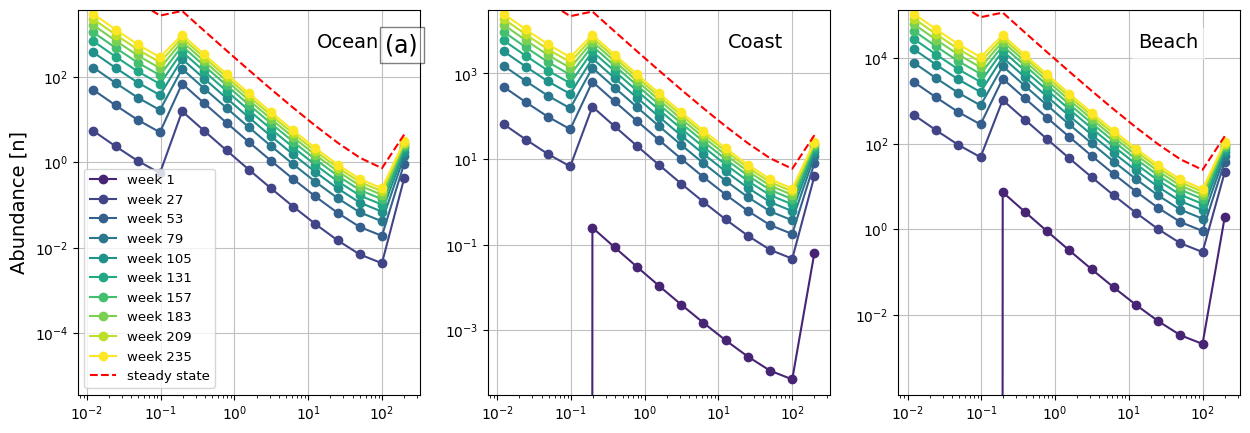

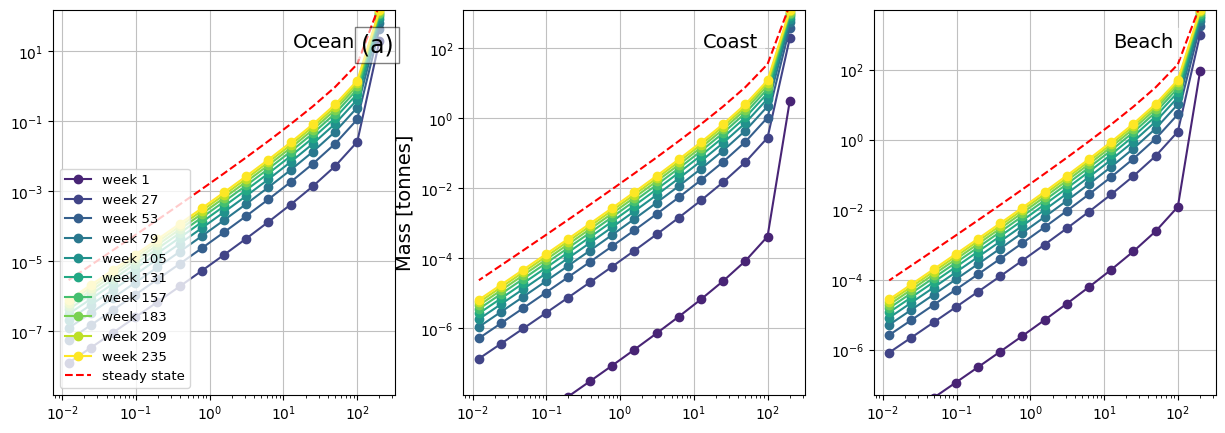

In [6]:
# figure settings
labelsize = 14
legendsize = 9.5
legendsize2 = 10
fig_res_NSD,ax_res_NSD = plt.subplots(1,3,figsize=(15,5),sharex='col')
fig_res_MSD,ax_res_MSD = plt.subplots(1,3,figsize=(15,5),sharex='col')

plot_evolution_N(ax_res_NSD[:],T_mat_N) 
# 仅根据transition matrix就能得出，这里定义的一次transition matrix运算意味着破碎进程推进了一周
plot_evolution_m(ax_res_MSD[:],T_mat_m,input_week)

9398.708677884493 2000.0008528792612
1) Baseline
------------case o ----------------
alpha: 2.51  sigma: 0.02
size range: from 0.138 mm, from index 4
------------case c ----------------
alpha: 2.51  sigma: 0.01
size range: from 0.138 mm, from index 4
------------case b ----------------
alpha: 2.51  sigma: 0.00
size range: from 0.138 mm, from index 4
------------case o m1 ----------------
alpha: 1.88  sigma: 0.08
size range: from 1.105 mm, from index 7
------------case o m2 ----------------
alpha: 1.60  sigma: 0.09
size range: from 1.105 mm, from index 7
------------case c m1 ----------------
alpha: 1.88  sigma: 0.03
size range: from 1.105 mm, from index 7
------------case c m2 ----------------
alpha: 1.59  sigma: 0.03
size range: from 1.105 mm, from index 7
Summary 1) Baseline: P_oo 7.2e-01-7.2e-01, P_oc 2.7e-01-2.7e-01, P_co 3.4e-02-3.4e-02, P_cc 8.3e-01-8.3e-01,           P_cb 1.3e-01, P_bc 3.2e-02-3.2e-02, P_bb 9.6e-01-9.6e-01, lambda 1.8e-02, P_s 5.1e-03
mean slopes, beach: nan, co

C:\Users\14090\AppData\Local\Temp\ipykernel_3976\4241317908.py:352: RuntimeWarning: divide by zero encountered in log2
  slopes_b = np.log2(N_b[mask_slope][1:])-np.log2(N_b[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_3976\4241317908.py:352: RuntimeWarning: invalid value encountered in subtract
  slopes_b = np.log2(N_b[mask_slope][1:])-np.log2(N_b[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_3976\4241317908.py:353: RuntimeWarning: divide by zero encountered in log2
  slopes_c = np.log2(N_c[mask_slope][1:])-np.log2(N_c[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_3976\4241317908.py:353: RuntimeWarning: invalid value encountered in subtract
  slopes_c = np.log2(N_c[mask_slope][1:])-np.log2(N_c[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipykernel_3976\4241317908.py:354: RuntimeWarning: divide by zero encountered in log2
  slopes_o = np.log2(N_o[mask_slope][1:])-np.log2(N_o[mask_slope][:-1])
C:\Users\14090\AppData\Local\Temp\ipyke

9378.965207006806 2000.0007657635376
2) Size dep. ocean transport
------------case o ----------------
alpha: 2.59  sigma: 0.02
size range: from 0.138 mm, from index 4
------------case c ----------------
alpha: 2.51  sigma: 0.01
size range: from 0.138 mm, from index 4
------------case b ----------------
alpha: 2.51  sigma: 0.00
size range: from 0.138 mm, from index 4
------------case o m1 ----------------
alpha: 1.91  sigma: 0.08
size range: from 1.105 mm, from index 7
------------case o m2 ----------------
alpha: 1.61  sigma: 0.09
size range: from 1.105 mm, from index 7
------------case c m1 ----------------
alpha: 1.88  sigma: 0.03
size range: from 1.105 mm, from index 7
------------case c m2 ----------------
alpha: 1.59  sigma: 0.03
size range: from 1.105 mm, from index 7
Summary 2) Size dep. ocean transport: P_oo 7.3e-01-8.7e-01, P_oc 1.2e-01-2.6e-01, P_co 3.2e-02-3.4e-02, P_cc 8.3e-01-8.3e-01,           P_cb 1.3e-01, P_bc 3.2e-02-3.2e-02, P_bb 9.6e-01-9.6e-01, lambda 1.8e-02, P_s 5

(0.001, 10000000000000.0)

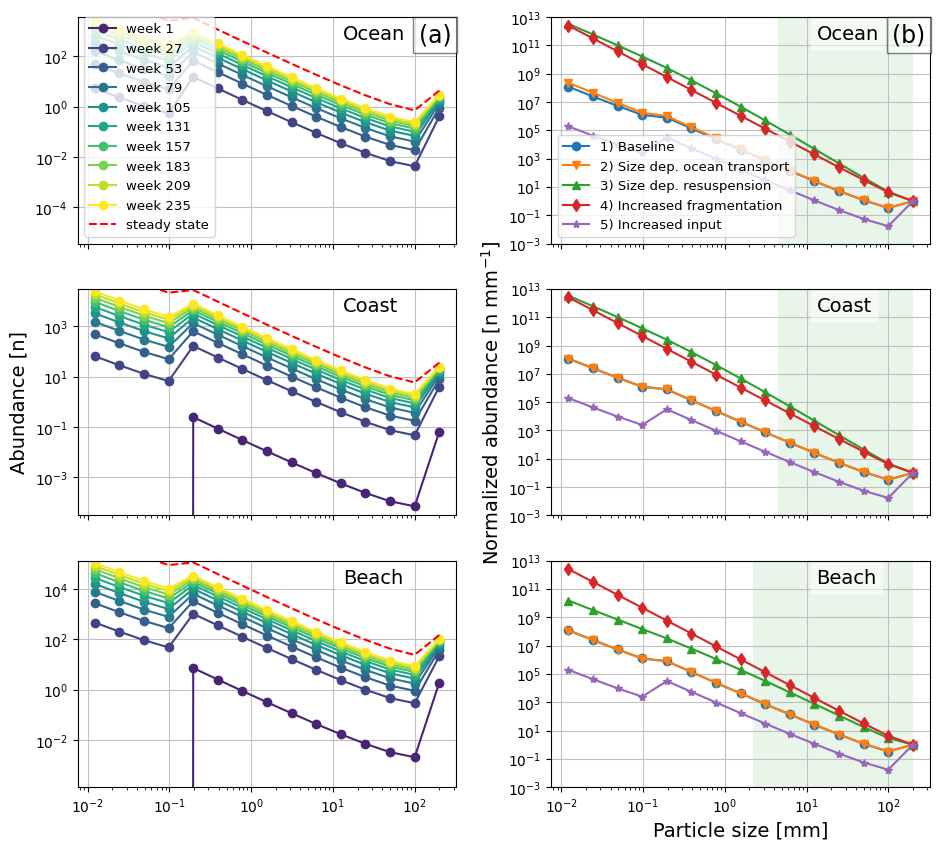

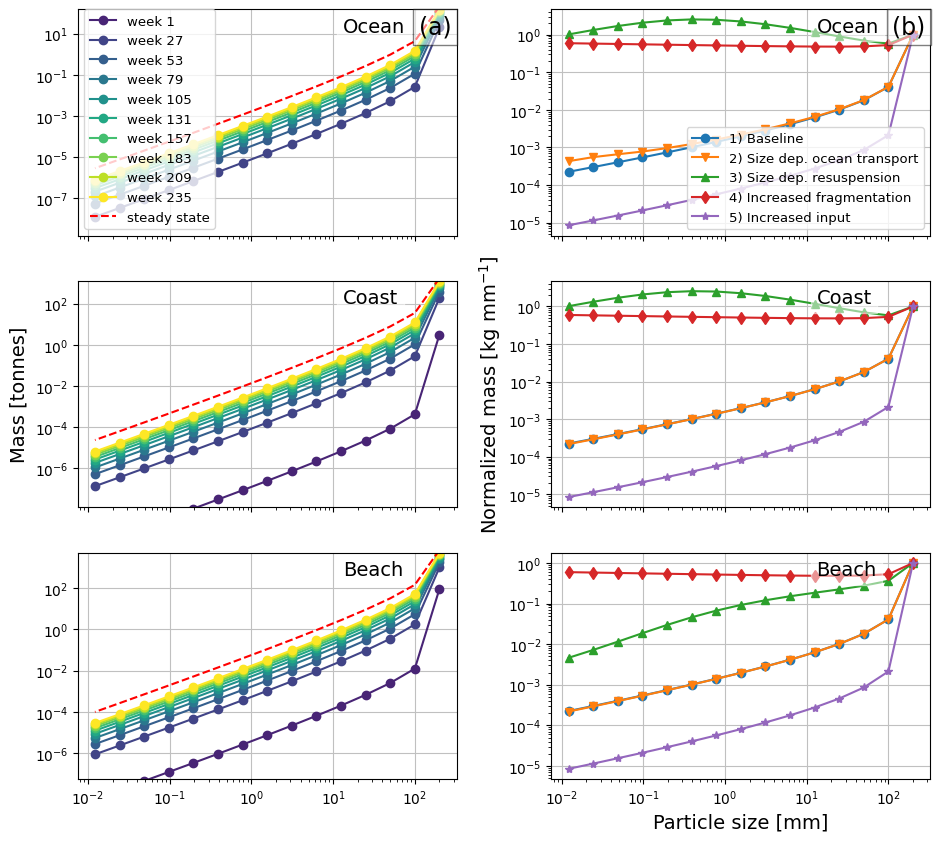

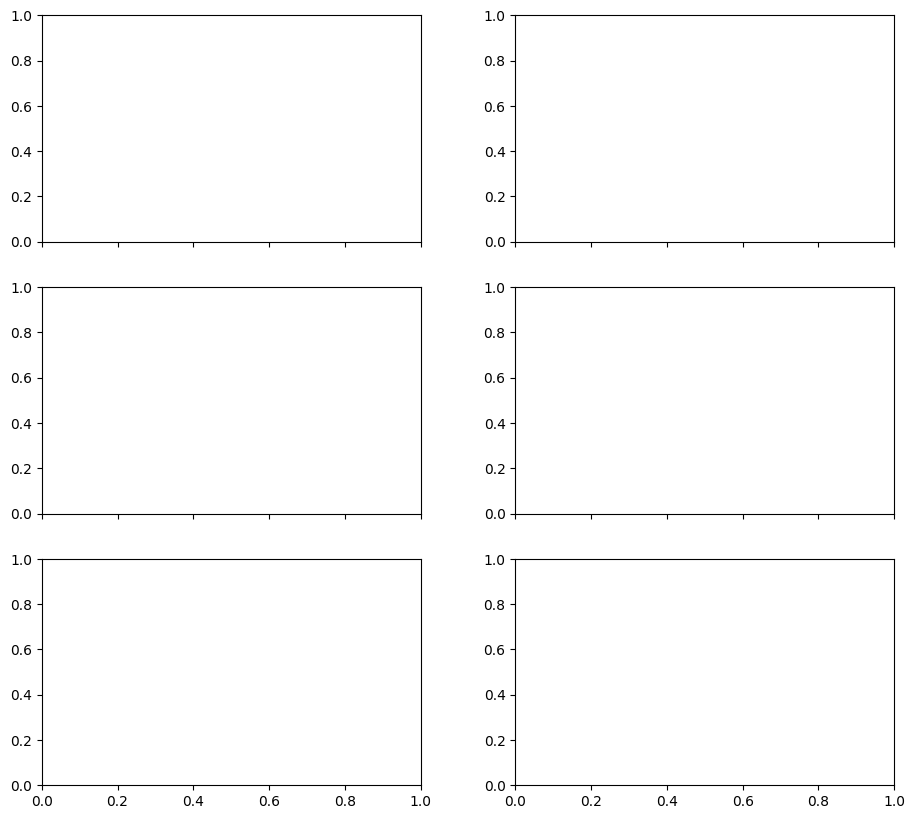

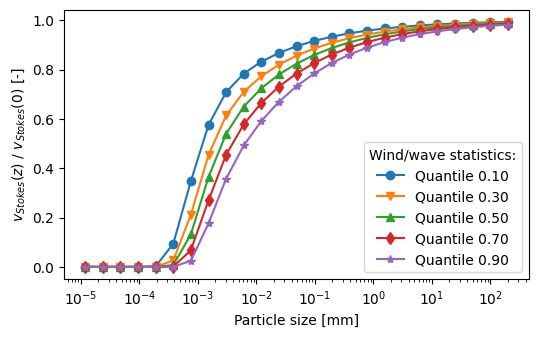

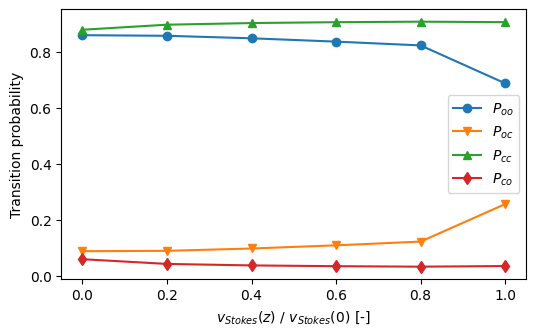

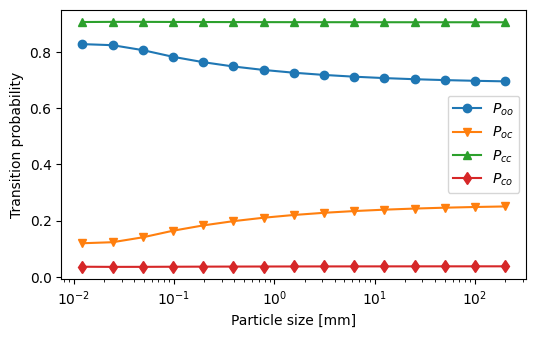

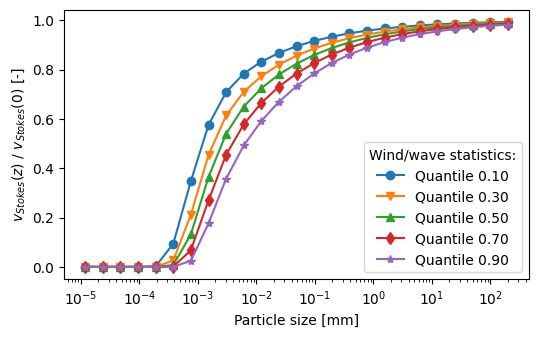

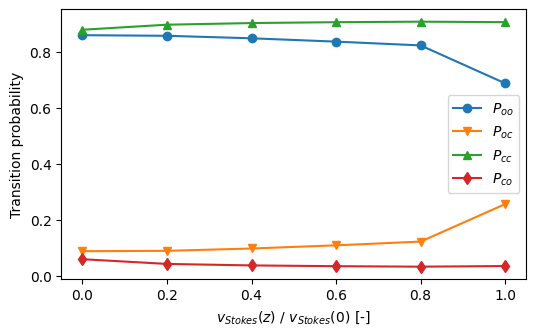

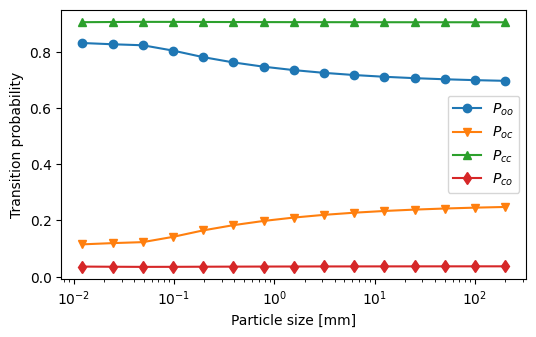

In [ ]:
labelsize = 14
legendsize = 9.5
legendsize2 = 10

fig_res_NSD,ax_res_NSD = plt.subplots(3,2,figsize=(11,10),sharex='col')
fig_res_MSD,ax_res_MSD = plt.subplots(3,2,figsize=(11,10),sharex='col')
fig_res_obs,ax_res_obs = plt.subplots(3,2,figsize=(11,10),sharex='col')

colors1 = plt.cm.tab10(np.linspace(0, 9, 10,dtype=int))
colors2 = plt.cm.Dark2(np.linspace(0, 11, 12,dtype=int))
colors = np.vstack((colors1, colors2))
mymap = mcolors.ListedColormap(colors)
linestyles = ['o-','v-','^-','d-','*-','x-']

for i1 in range(len(ss['scenario'])):
    
    k_arr = np.arange(0,15,1)
    L0 = 200
    l_arr = np.array([L0/(2**k_) for k_ in k_arr])
    
    k_bins = np.arange(-.5,15.5,1)
    b_model = np.array([L0/(2**k_bin) for k_bin in k_bins])
    
    index_o = np.arange(len(k_arr))
    index_c = np.arange(len(k_arr),2*len(k_arr))
    index_b = np.arange(2*len(k_arr),3*len(k_arr))

    N_ss,m_ss,p_dict,d_if_week,p_s,res_dict,T_mat_N,T_mat_m =  calculate_results(ss,i1)    

    pdf_N_o,pdf_N_c,pdf_N_b = pmf_to_pdf(N_ss)
    pdf_m_o,pdf_m_c,pdf_m_b = pmf_to_pdf(m_ss)
    
    N_ss_o = N_ss[index_o]
    N_ss_c = N_ss[index_c]
    N_ss_b = N_ss[index_b]

    N_ss_o_m1 = correct_vertical_mixing(l_arr, N_ss_o, data_S['U10'][q1],data_S['H_s'][q1],d_net)
    N_ss_o_m2 = correct_vertical_mixing(l_arr, N_ss_o, data_S['U10'][q2],data_S['H_s'][q2],d_net)
    N_ss_c_m1 = correct_vertical_mixing(l_arr, N_ss_c, data_S['U10'][q1],data_S['H_s'][q1],d_net)
    N_ss_c_m2 = correct_vertical_mixing(l_arr, N_ss_c, data_S['U10'][q2],data_S['H_s'][q2],d_net)
        
    b = np.flip(b_model)
    lowerbound = True
    cases = ['o','c','b','o m1','o m2','c m1','c m2']
    print(ss['scenario'][i1])
    up_to = None
    for N_,case_ in zip([N_ss_o,N_ss_c,N_ss_b,N_ss_o_m1,N_ss_o_m2,N_ss_c_m1,N_ss_c_m2],cases):
        print('------------case %s ----------------' %case_)
        h = np.flip(N_)
        alpha_opt,i_min_opt,KS_opt = calculate_powerlaw_parameters(b[:up_to],h[:up_to],lowerbound,plot=False)
        alpha_fit,sigma_fit = calculate_alpha_sigma(alpha_opt,b[:up_to],h[:up_to],i_min_opt)


    print('Summary %s: P_oo %2.1e-%2.1e, P_oc %2.1e-%2.1e, P_co %2.1e-%2.1e, P_cc %2.1e-%2.1e, \
          P_cb %2.1e, P_bc %2.1e-%2.1e, P_bb %2.1e-%2.1e, lambda %2.1e, P_s %2.1e' % (ss['scenario'][i1],p_dict['oo'].min(),p_dict['oo'].max(),p_dict['oc'].min(),
          p_dict['oc'].max(),p_dict['co'].min(),p_dict['co'].max(),p_dict['cc'].min(),p_dict['cc'].max(),p_dict['cb'],p_dict['bc'].min(),p_dict['bc'].max(),
          p_dict['bb'].min(),p_dict['bb'].max(),d_if_week*52,p_s))
 
    if i1 == 0:
        input_week = ss['input_year'][i1]/52

        plot_evolution_N(ax_res_NSD[:,0],T_mat_N)
        plot_evolution_m(ax_res_MSD[:,0],T_mat_m,input_week)
    cmap = mymap
    
    if i1 == 5:
        pass
    else:
        ax_res_NSD[0,1].loglog(l_arr,pdf_N_o,linestyles[i1],color=cmap(i1),label=ss['scenario'][i1])
        ax_res_NSD[1,1].loglog(l_arr,pdf_N_c,linestyles[i1],color=cmap(i1))
        ax_res_NSD[2,1].loglog(l_arr,pdf_N_b,linestyles[i1],color=cmap(i1))
        ax_res_NSD[0,1].legend(loc='lower left',fontsize=legendsize)
        ax_res_NSD[1,1].set_ylabel('Normalized abundance [n mm$^{-1}$]',fontsize=labelsize)
        ax_res_NSD[2,1].set_xlabel('Particle size [mm]',fontsize=labelsize)
        if i1 == 2:
            x_fill_0 = [4.419,200]
            x_fill_1 = [4.419,200]
            x_fill_2 = [2.210,200]
            ax_res_NSD[0,1].fill_between(x_fill_0, 1e-3, 1e15, facecolor=cmap(i1), alpha=.1, zorder=0)
            ax_res_NSD[1,1].fill_between(x_fill_1, 1e-3, 1e15, facecolor=cmap(i1), alpha=.1, zorder=0)
            ax_res_NSD[2,1].fill_between(x_fill_2, 1e-3, 1e15, facecolor=cmap(i1), alpha=.1, zorder=0)
        
        ax_res_MSD[0,1].loglog(l_arr,pdf_m_o,linestyles[i1],color=cmap(i1),label=ss['scenario'][i1])
        ax_res_MSD[1,1].loglog(l_arr,pdf_m_c,linestyles[i1],color=cmap(i1))
        ax_res_MSD[2,1].loglog(l_arr,pdf_m_b,linestyles[i1],color=cmap(i1))
        ax_res_MSD[0,1].legend(loc='lower right',fontsize=legendsize)
        ax_res_MSD[1,1].set_ylabel('Normalized mass [kg mm$^{-1}$]',fontsize=labelsize)
        ax_res_MSD[2,1].set_xlabel('Particle size [mm]',fontsize=labelsize)
        
set_plot_labels(ax_res_NSD[:,1],[pdf_N_o,pdf_N_c,pdf_N_b],collabel='(b)')
set_plot_labels(ax_res_MSD[:,1],[pdf_m_o,pdf_m_c,pdf_m_b],collabel='(b)')

fig_res_NSD.subplots_adjust(wspace=.25)    
fig_res_MSD.subplots_adjust(wspace=.25)    
fig_res_obs.subplots_adjust(wspace=.25)    

ax_res_NSD[0,1].set_ylim(1e-3,1e13)
ax_res_NSD[1,1].set_ylim(1e-3,1e13)
ax_res_NSD[2,1].set_ylim(1e-3,1e13)